# Deep Convolutional Autoencoders on MNist Digits
## Chris Tralie

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import time

# Dataset

In [2]:
torch.manual_seed(1)
#Converting data to torch.FloatTensor and padding to 32x32
transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])
data_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
data_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Architecture

In [3]:
class AutoencoderCNN(nn.Module):
    def __init__(self, X, depth=4, dim_latent=2):
        """
        X: an example batch
        depth: int
            How many convolutional layers there are in the encoder/decoder
        dim_latent: int
            Dimension of the latent space
        """
        super(AutoencoderCNN, self).__init__()
        
        ## Step 1: Create the convolutional down layers
        last_channels = 1
        channels = 32
        down = []
        for i in range(depth):
            conv = nn.Conv2d(last_channels, channels, 3, stride=2, padding=1)
            last_channels = channels
            channels *= 2
            down.append(conv)
        y = X
        for layer in down:
            y = layer.to(X.device)(y)
        shape = y.shape[1::]
        down.append(nn.Flatten())
        y = down[-1](y)
        dim = y.shape[-1]
        self.down = nn.Sequential(*down)
        
        ## Step 2: Setup latent space encoder/decoder
        self.latentdown = nn.Sequential(nn.Linear(dim, dim_latent), nn.Sigmoid())
        self.latentup = nn.Sequential(nn.Linear(dim_latent, dim), nn.LeakyReLU())
        
        ## Step 3: Create the convolutional up layers
        up = [nn.Unflatten(1, shape)]
        channels = last_channels//2
        for i in range(depth):
            # Use upsampling with bilinear interpolation instead of ConvTranspose
            # to avoid checkerboard artifacts
            upsample = nn.Upsample(scale_factor=2, mode='bilinear')
            convup = nn.Conv2d(last_channels, channels, 3, stride=1, padding=1)
            up.append(upsample)
            up.append(convup)
            up.append(nn.LeakyReLU())
            last_channels = channels
            if i == depth-2:
                channels = 1
            else:
                channels = channels // 2
        self.up = nn.Sequential(*up)
    
    def forward(self, x, verbose=False):
        y = x
        if verbose:
            print(y.shape)
        for layer in self.down + self.latentdown + self.latentup + self.up:
            y = layer(y)
            if verbose:
                print(y.shape)
        return y
    
    def encode(self, x):
        return self.latentdown(self.down(x))
    
    def decode(self, x):
        return self.up(self.latentup(x))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
X, Y = next(iter(train_loader))
X = X.to(device)

model = AutoencoderCNN(X, depth=4, dim_latent=2)
model = model.to(device)
print(len(list(model.parameters())))
model(X, True); # Print out an example of passing through all layers

20
torch.Size([32, 1, 32, 32])
torch.Size([32, 32, 16, 16])
torch.Size([32, 64, 8, 8])
torch.Size([32, 128, 4, 4])
torch.Size([32, 256, 2, 2])
torch.Size([32, 1024])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 1024])
torch.Size([32, 1024])
torch.Size([32, 256, 2, 2])
torch.Size([32, 256, 4, 4])
torch.Size([32, 128, 4, 4])
torch.Size([32, 128, 4, 4])
torch.Size([32, 128, 8, 8])
torch.Size([32, 64, 8, 8])
torch.Size([32, 64, 8, 8])
torch.Size([32, 64, 16, 16])
torch.Size([32, 32, 16, 16])
torch.Size([32, 32, 16, 16])
torch.Size([32, 32, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])


# Plotting Utilities

In [4]:
def get_color_digit(img, label):
    """
    Convert a grayscale digit to one with a background color chosen from
    the tab10 colorcycle to indicate its class
    """
    c = plt.get_cmap("tab10")
    C = c([label]).flatten()[0:3]
    ret = (1-img)[:, :, None]*C[None, None, :]
    return ret

def plot_digits_latent(model, dataset, device, n_digits, seed=0):
    """
    Plot a set of example digits projected to the latent space
    
    Parameters
    ----------
    model: torch model
        The autoencoder
    dataset: torch.Dataset
        Dataset of digits to display
    device: string
        Torch device
    n_digits: int
        Number of digits to plot in the latent space
    seed: int
        Seed loader so that we get the same random examples each time
    """
    # https://pytorch.org/docs/stable/notes/randomness.html
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        numpy.random.seed(worker_seed)
        random.seed(worker_seed)
    g = torch.Generator()
    g.manual_seed(seed)
    
    loader = torch.utils.data.DataLoader(dataset, n_digits, shuffle=True, worker_init_fn=seed_worker, generator=g)
    data, labels = next(iter(loader))
    ax = plt.gca()
    labels = labels.numpy()
    data = data.to(device)
    res = model.encode(data)
    if not device == "cpu":
        data = data.cpu()
        res = res.cpu()
    res = res.detach().numpy()
    data = data.detach().numpy()
    encoded_imgs = np.array([])
    for k in range(data.shape[0]):
        x, y = res[k, :]
        img = get_color_digit(data[k, 0, :, :], labels[k])
        img = OffsetImage(img, zoom=0.7)
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
        if encoded_imgs.size == 0:
            encoded_imgs = res
        else:
            encoded_imgs = np.concatenate((encoded_imgs, res), axis=0)

    plt.title("Latent Space")
    ax.update_datalim(encoded_imgs)
    ax.autoscale()

def plot_model_examples(model, dataset, device, K, n_digits, loss=None):
    """
    Look at the images of a few digits before and after the network, as well
    as a plot of some digits in the latent space
    
    Parameters
    ----------
    model: torch model
        The autoencoder
    dataset: torch.Dataset
        Dataset of digits to display
    device: string
        Torch device
    K: int
        Number of rows of digits to display
    n_digits: int
        Number of digits to plot in the latent space
    """
    cols = int(np.ceil(K/4))*2
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=K*(cols//2), shuffle=True)
    for data in loader:
        labels = data[1].numpy()
        # Go through until we find a batch where we have at least one of every number
        if len(np.unique(labels[0:30])) == 10:
            break
    data, labels = data   
    data = data.to(device)
    labels = labels.numpy()
    res = model(data)
    orig = data
    if not device == "cpu":
        orig = orig.cpu()
        res = res.cpu()
    orig = orig.detach().numpy()
    res = res.detach().numpy()
    for i in range(K):
        for j in range(cols//2):
            k = i*cols//2 + j
            plt.subplot2grid((K, cols*2), (i, j*2))
            
            img = get_color_digit(orig[k, 0, :, :], labels[k])
            plt.imshow(img)
            plt.axis("off")
            if i == 0:
                plt.title("Original")
            plt.subplot2grid((K, cols*2), (i, j*2+1))
            plt.imshow(res[k, 0, :, :], cmap='gray_r')
            if i == 0:
                plt.title("Reconstructed")
            plt.axis("off")
    plt.subplot2grid((K, cols*2), (0, cols), rowspan=K-2, colspan=cols)
    plot_digits_latent(model, dataset, device, n_digits)
    if loss:
        plt.title("Latent Space, Loss={:.3f}".format(loss))

# Training Loop

Device:  cuda
12
Epoch 0, loss 78.043
Epoch 1, loss 73.162
Epoch 2, loss 71.832
Epoch 3, loss 71.126
Epoch 4, loss 70.698
Epoch 5, loss 70.331
Epoch 6, loss 70.049
Epoch 7, loss 69.860
Epoch 8, loss 69.672
Epoch 9, loss 69.504
Epoch 10, loss 69.367
Epoch 11, loss 69.210
Epoch 12, loss 69.098
Epoch 13, loss 68.975
Epoch 14, loss 68.891
Epoch 15, loss 68.806
Epoch 16, loss 68.698
Epoch 17, loss 68.644
Epoch 18, loss 68.566
Epoch 19, loss 68.488


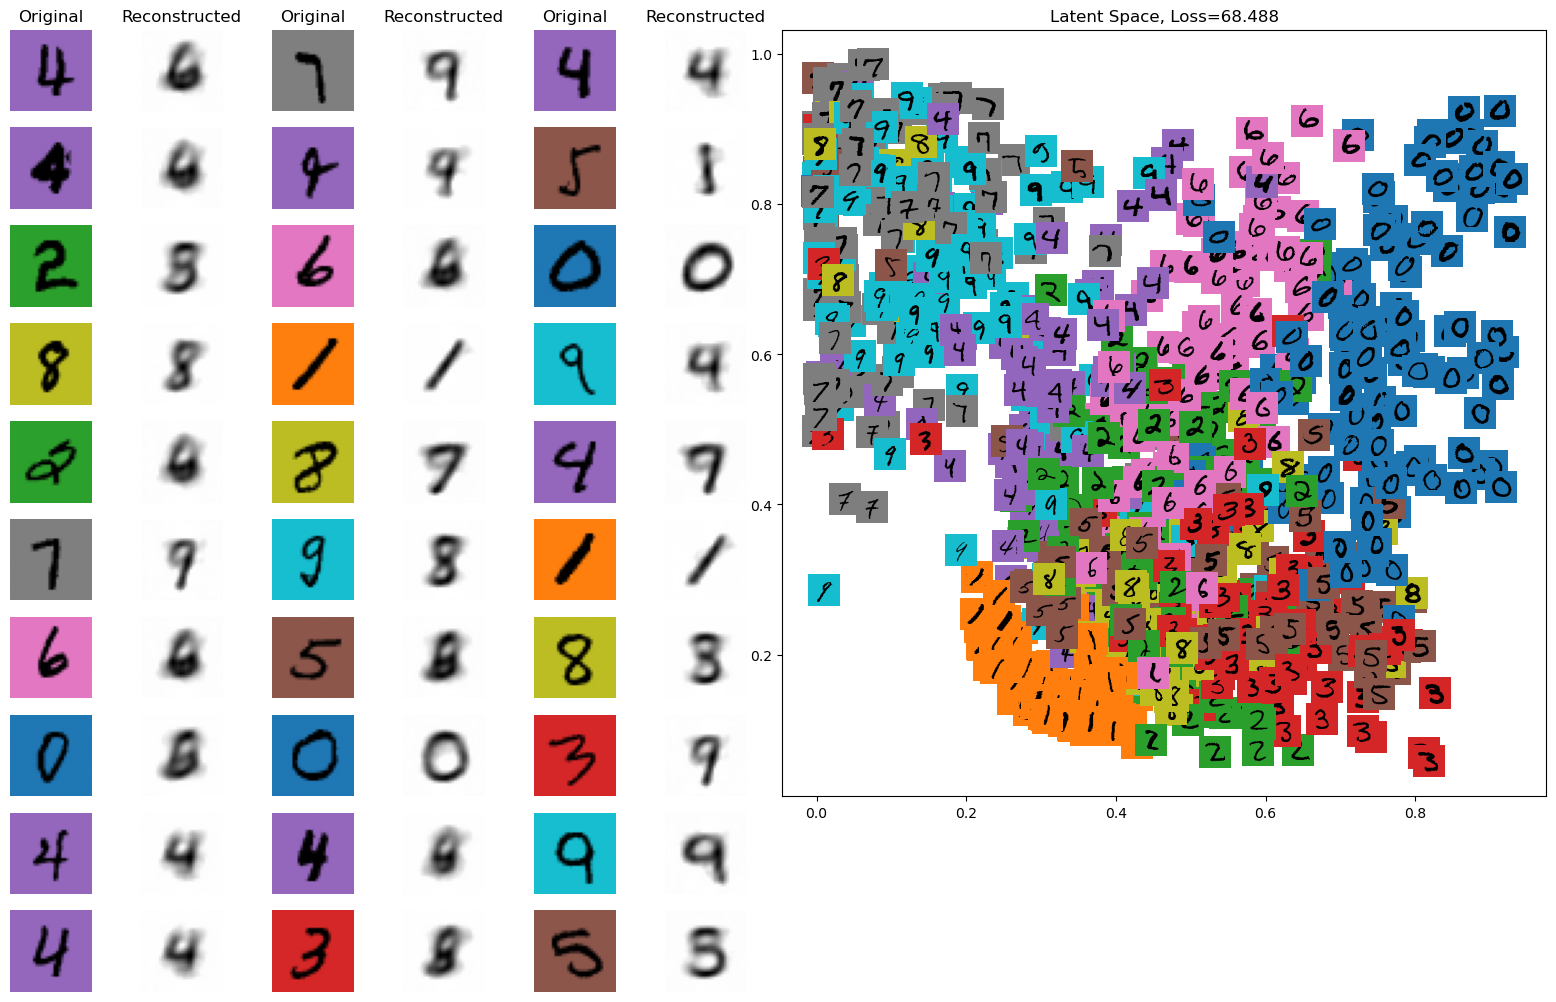

In [5]:
# Try to use the GPU

print("Device: ", device)

## Step 2: Create model with a test batch
X, Y = next(iter(train_loader))
X = X.to(device)
model = AutoencoderCNN(X, depth=2)
model = model.to(device)
print(len(list(model.parameters())))

## Step 3: Setup the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

n_epochs = 20 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
train_losses = []

fac = 0.5
plt.figure(figsize=(fac*40, fac*25))

for epoch in range(n_epochs):
    loader = DataLoader(data_train, batch_size=32, shuffle=True)
    train_loss = 0
    for X, Y in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        X = X.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        X_est = model(X)
        # Compute the loss function comparing Y_est to Y
        loss = loss_fn(X, X_est)
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        train_loss += loss.item()
    
    
    X = X.detach().cpu()
    X_est = X_est.detach().cpu()
    
    plt.clf()
    plot_model_examples(model, data_test, device, K=10, n_digits=1000, loss=train_loss)
    plt.savefig("DigitsTrain{}.png".format(epoch))
    print("Epoch {}, loss {:.3f}".format(epoch, train_loss))
    train_losses.append(train_loss)

# Decoding Examples

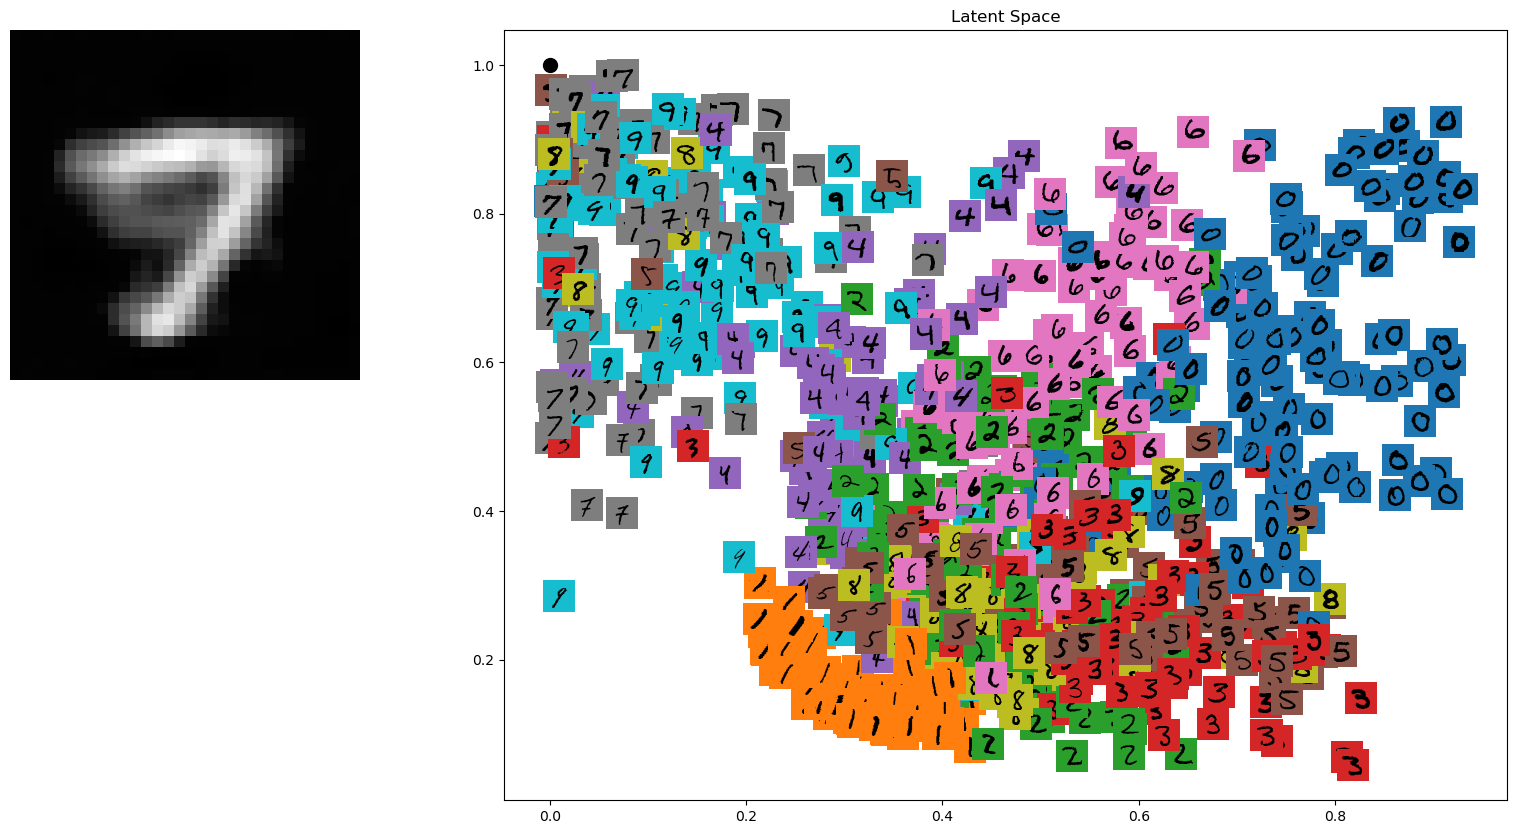

In [6]:
plt.figure(figsize=(20, 10))


u1 = np.array([1, 0])
u2 = np.array([0, 1])

for i, t in enumerate(np.linspace(0, 1, 200)):
    u = np.array(u1*(1-t)+t*u2)
    ut = torch.tensor([[u[0], u[1]]], dtype=torch.float32).to(device)
    res = model.decode(ut)[0, 0, :, :].detach().cpu()
    
    plt.subplot2grid((2, 3), (0, 0))
    plt.imshow(res, cmap='gray')
    plt.axis("off")
    
    plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
    plot_digits_latent(model, data_test, device, n_digits=1000, seed=0)
    plt.scatter(u[0], u[1], s=100, zorder=10, c='k')
    plt.savefig("LatentTraverse{}.png".format(i))